In [1]:
import pandas as pd
from collections import Counter
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import nltk

In [2]:
# Download NLTK resources
nltk = nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stoic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load datasets from basically ../../Dataset
train_data = pd.read_csv('../../Dataset/train_data_cleaned.csv')
val_data = pd.read_csv('../../Dataset/val_data_cleaned.csv')
test_data = pd.read_csv('../../Dataset/test_data_cleaned.csv')

all_data = pd.concat([train_data, val_data, test_data], ignore_index=True)

In [4]:
# Combine title and text into one column
all_data["content"] = all_data["title"].fillna("") + " " + all_data["text"].fillna("")

In [5]:
all_data

,id,title,text,label,content
0,6026,"Whether Clinton or Trump, Tensions Will Escala...",by Jerri-Lynn Scofield \nJerri-Lynn here: Ther...,0,"Whether Clinton or Trump, Tensions Will Escala..."
1,1553,"If this is what a “Rubio surge” looks like, Re...","On one hand, it is yet another example of how ...",1,"If this is what a “Rubio surge” looks like, Re..."
2,2581,Boehner moves to push off immigration fight to...,House Speaker John Boehner announced plans Tue...,1,Boehner moves to push off immigration fight to...
3,9374,Police Depts. Paid AT&T Millions To Scrutinize...,"Edmondo Burr in News , US // 0 Comments Adam...",0,Police Depts. Paid AT&T Millions To Scrutinize...
4,4448,Poll: 6 in 10 Back Renewal of NSA Data Collection,With the provisions of the Patriot Act which a...,1,Poll: 6 in 10 Back Renewal of NSA Data Collect...
...,...,...,...,...,...
6005,220,The right turns on Paul Ryan: Yesterday’s cons...,Rush Limbaugh: “I don’t remember a vice presid...,1,The right turns on Paul Ryan: Yesterday’s cons...
6006,7211,"“We are losing control of the streets,” say po...",BNI Store Nov 2 2016 “We are losing control of...,0,"“We are losing control of the streets,” say po..."
6007,3652,"FBI: Orlando suspect U.S. citizen, vowed alleg...","PORT ST. LUCIE, Fla. — Investigators were revi...",1,"FBI: Orlando suspect U.S. citizen, vowed alleg..."
6008,6239,"Meter Reader Knocks On Man’s Door, Reveals Sin...",Share This \nWhen a man heard a knock on his d...,0,"Meter Reader Knocks On Man’s Door, Reveals Sin..."


In [6]:
# Verify that the data is loaded correctly
print(f"Total articles: {len(all_data)}")
print(all_data.head())

Total articles: 6010
     id                                              title  \
0  6026  Whether Clinton or Trump, Tensions Will Escala...   
1  1553  If this is what a “Rubio surge” looks like, Re...   
2  2581  Boehner moves to push off immigration fight to...   
3  9374  Police Depts. Paid AT&T Millions To Scrutinize...   
4  4448  Poll: 6 in 10 Back Renewal of NSA Data Collection   

                                                text  label  \
0  by Jerri-Lynn Scofield \nJerri-Lynn here: Ther...      0   
1  On one hand, it is yet another example of how ...      1   
2  House Speaker John Boehner announced plans Tue...      1   
3    Edmondo Burr in News , US // 0 Comments Adam...      0   
4  With the provisions of the Patriot Act which a...      1   

                                             content  
0  Whether Clinton or Trump, Tensions Will Escala...  
1  If this is what a “Rubio surge” looks like, Re...  
2  Boehner moves to push off immigration fight to...  
3  Poli

In [7]:
# Drop rows with missing or empty content
all_data = all_data[all_data["content"].str.strip() != ""]

In [8]:
all_data

,id,title,text,label,content
0,6026,"Whether Clinton or Trump, Tensions Will Escala...",by Jerri-Lynn Scofield \nJerri-Lynn here: Ther...,0,"Whether Clinton or Trump, Tensions Will Escala..."
1,1553,"If this is what a “Rubio surge” looks like, Re...","On one hand, it is yet another example of how ...",1,"If this is what a “Rubio surge” looks like, Re..."
2,2581,Boehner moves to push off immigration fight to...,House Speaker John Boehner announced plans Tue...,1,Boehner moves to push off immigration fight to...
3,9374,Police Depts. Paid AT&T Millions To Scrutinize...,"Edmondo Burr in News , US // 0 Comments Adam...",0,Police Depts. Paid AT&T Millions To Scrutinize...
4,4448,Poll: 6 in 10 Back Renewal of NSA Data Collection,With the provisions of the Patriot Act which a...,1,Poll: 6 in 10 Back Renewal of NSA Data Collect...
...,...,...,...,...,...
6005,220,The right turns on Paul Ryan: Yesterday’s cons...,Rush Limbaugh: “I don’t remember a vice presid...,1,The right turns on Paul Ryan: Yesterday’s cons...
6006,7211,"“We are losing control of the streets,” say po...",BNI Store Nov 2 2016 “We are losing control of...,0,"“We are losing control of the streets,” say po..."
6007,3652,"FBI: Orlando suspect U.S. citizen, vowed alleg...","PORT ST. LUCIE, Fla. — Investigators were revi...",1,"FBI: Orlando suspect U.S. citizen, vowed alleg..."
6008,6239,"Meter Reader Knocks On Man’s Door, Reveals Sin...",Share This \nWhen a man heard a knock on his d...,0,"Meter Reader Knocks On Man’s Door, Reveals Sin..."


In [9]:
# Preprocessing function
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [10]:
def preprocess_text_advanced(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = " ".join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

In [11]:
# Apply preprocessing
all_data["content_cleaned"] = all_data["content"].apply(preprocess_text_advanced)

In [12]:
# Analyze word frequency in fake vs real news
fake_text = " ".join(all_data[all_data["label"] == 0]["content_cleaned"])
real_text = " ".join(all_data[all_data["label"] == 1]["content_cleaned"])

fake_words = Counter(fake_text.split())
real_words = Counter(real_text.split())

print("Most common words in Fake News:", fake_words.most_common(10))
print("Most common words in Real News:", real_words.most_common(10))

Most common words in Fake News: [('clinton', 7130), ('us', 6874), ('trump', 6866), ('peopl', 5408), ('state', 5382), ('one', 5157), ('would', 4772), ('hillari', 4767), ('elect', 4075), ('like', 4017)]
Most common words in Real News: [('said', 17104), ('trump', 16001), ('clinton', 11094), ('state', 10072), ('republican', 8172), ('would', 7744), ('presid', 6870), ('say', 6734), ('one', 6630), ('campaign', 6298)]


In [13]:
# Feature representation with advanced embeddings
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(all_data["content_cleaned"].tolist())

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\stoic\miniconda3\envs\llms_env\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\stoic\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
# Dimensionality Reduction with PCA
pca = PCA(n_components=50, random_state=42)  # Reduce to 50 dimensions for clustering
reduced_embeddings = pca.fit_transform(embeddings)

In [15]:
# Apply K-Means with different k values
for k in range(2, 6):  # Test k=2, 3, 4, 5
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(reduced_embeddings)
    silhouette_avg = silhouette_score(reduced_embeddings, kmeans_labels)
    print(f"K={k}, Silhouette Score: {silhouette_avg:.2f}")

K=2, Silhouette Score: 0.11
K=3, Silhouette Score: 0.05
K=4, Silhouette Score: 0.07
K=5, Silhouette Score: 0.08


In [16]:
# Final K-Means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(reduced_embeddings)
all_data["cluster"] = kmeans_labels

In [17]:
# Evaluate clustering
silhouette_avg = silhouette_score(reduced_embeddings, kmeans_labels)
ari = adjusted_rand_score(all_data["label"], kmeans_labels)
print(f"Final Silhouette Score (K-Means, k=2): {silhouette_avg:.2f}")
print(f"Adjusted Rand Index: {ari:.2f}")

Final Silhouette Score (K-Means, k=2): 0.11
Adjusted Rand Index: 0.07


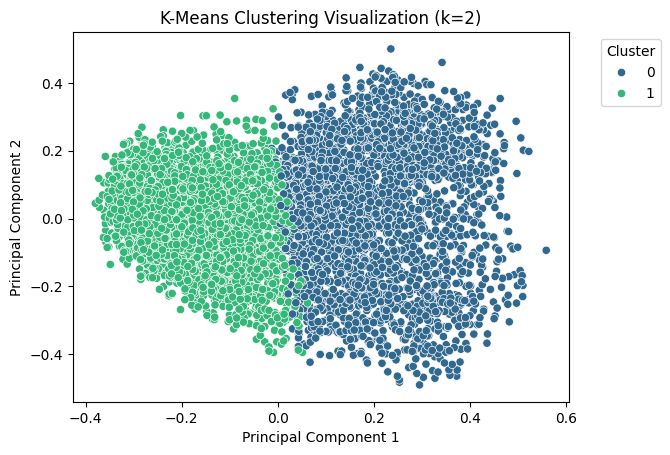

In [18]:
# Visualize Clusters with PCA (2D)
pca_2d = PCA(n_components=2)
reduced_data_2d = pca_2d.fit_transform(reduced_embeddings)

sns.scatterplot(x=reduced_data_2d[:, 0], y=reduced_data_2d[:, 1], hue=kmeans_labels, palette="viridis")
plt.title("K-Means Clustering Visualization (k=2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

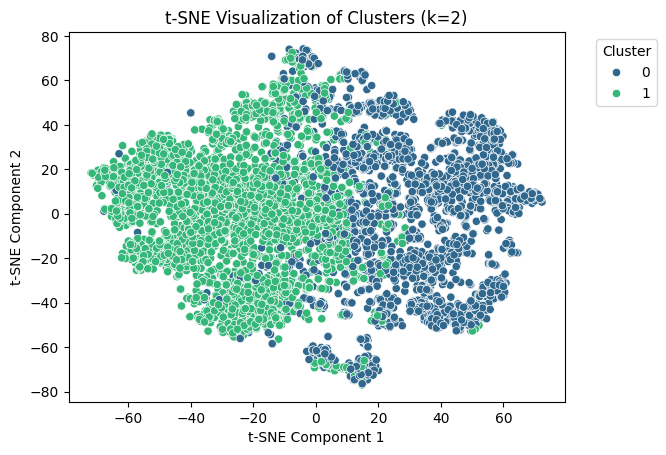

In [19]:
# Visualize Clusters with t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(reduced_embeddings)

sns.scatterplot(x=reduced_data_tsne[:, 0], y=reduced_data_tsne[:, 1], hue=kmeans_labels, palette="viridis")
plt.title("t-SNE Visualization of Clusters (k=2)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [20]:
# Analyze cluster distribution
print(all_data.groupby("cluster").size())

cluster
0    2687
1    3323
dtype: int64


In [21]:
# Save results to CSV for further analysis
all_data[["id", "title", "text", "label", "cluster"]].to_csv("kmeans_optimized_clustering_results.csv", index=False)
print("Clustering results saved to kmeans_optimized_clustering_results.csv")

Clustering results saved to kmeans_optimized_clustering_results.csv


In [22]:
# Let's also calculate the accuracy of the clustering, because in the all_data we have the label of the article and compare it with the cluster
# We can calculate the accuracy
accuracy = sum(all_data["label"] == all_data["cluster"]) / len(all_data)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.63
